In [ ]:
import os 
import glob
import pysam
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [64]:
# ~ 1 minute
alleleTable = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/SG-BULK/AlleleTable.concat.tsv', sep='\t')
alleleTable['diff'] = alleleTable['read_STR_length'] - alleleTable['reference_STR_allele']

crude_STR_profile = list()
for patient_id, edf in alleleTable.groupby("patient_id"):
    crude_STR_profile.append( [patient_id, len(edf), np.mean( edf['diff'] )] )
crude_STR_profile = pd.DataFrame(crude_STR_profile, columns=['sample_id', 'n_reads', 'avg_diff'])

In [ ]:
DIR_FASTQ = '/node200data/18parkky/datasets/data/public/FASTQ/SG-BULK'
DIR_FASTQ_MSI = f'{DIR_FASTQ}/MSI'
DIR_FASTQ_MSS = f'{DIR_FASTQ}/MSS'

list_DIR_FASTQ_MSI_by_sample = [ d for d in glob.glob( f'{DIR_FASTQ_MSI}/*' ) if os.path.isdir(d)==True and len(d.split("_")) == 1 and 'EGAF' not in d.split("/")[-1] ]
list_DIR_FASTQ_MSS_by_sample = [ d for d in glob.glob( f'{DIR_FASTQ_MSS}/*' ) if os.path.isdir(d)==True and len(d.split("_")) == 1 and 'EGAF' not in d.split("/")[-1] ]

In [ ]:
DIR_BAM_out = '/node200data/18parkky/datasets/data/public/BAM/Joanito_et_al/SG-BULK/nonhost-reads'
DIR_processed_BAM_MSI_out = f'{DIR_BAM_out}/MSI'
DIR_processed_BAM_MSS_out = f'{DIR_BAM_out}/MSS'

processed_MSI_samples = { d.split("/")[-1].split(".")[0] for d in glob.glob(f'{DIR_processed_BAM_MSI_out}/*') if os.path.isfile(d)==True and d.split("/")[-1].split(".")[-1] == 'bam'}
processed_MSS_samples = { d.split("/")[-1].split(".")[0] for d in glob.glob(f'{DIR_processed_BAM_MSS_out}/*') if os.path.isfile(d)==True and d.split("/")[-1].split(".")[-1] == 'bam'}

processed_MSI_samples, len(processed_MSI_samples)

({'1054', '1236', '1253', '1627', '1657', '609', '612', '649'}, 8)

## Run bowtie2 to human genome

In [ ]:
DIR_BAM_MSI_out = '/node200data/18parkky/datasets/data/public/BAM/Joanito_et_al/SG-BULK/MSI/raw'

In [109]:
# (1) Run bowtie2 to human reference genome
#! Bowtie 2 parameters
num_threads = 12
DIR_bowtie2_index = '/node200data/18parkky/datasets/reference/z_program_references/bowtie2/hg38/hg38'


with open( '/home/18parkky/git/CRC_MSI_intensity_analysis/scripts/Joanito/bulkRNAseq/microbial_read_analysis/temp.sh', 'w' ) as bash_script:
    # MSI
    for DIR_FASTQ_MSI in list_DIR_FASTQ_MSI_by_sample:
        sample_id = DIR_FASTQ_MSI.split("/")[-1]
        
        if sample_id in processed_MSI_samples:
            continue
        
        else:        
            # print(f'Running pipeline for {sample_id}', flush=True)
            
            PATH_R1, PATH_R2 = f'{DIR_FASTQ_MSI}/{sample_id}_R1.fastq.gz', f'{DIR_FASTQ_MSI}/{sample_id}_R2.fastq.gz'
            PATH_BAM_out = f'{DIR_BAM_MSI_out}/{sample_id}.sorted.bam'
            cmd = f'bowtie2 -p {num_threads} -x {DIR_bowtie2_index} -1 {PATH_R1} -2 {PATH_R2} | samtools view -Sb | samtools sort -@ {num_threads} > {PATH_BAM_out}'
            bash_script.write(f'{cmd}\n')
            cmd = f'samtools index {PATH_BAM_out} -@ {num_threads}'
            bash_script.write(f'{cmd}\n')

In [ ]:
# (2) Extract unmapped reads
with open( '/home/18parkky/git/CRC_MSI_intensity_analysis/scripts/Joanito/bulkRNAseq/microbial_read_analysis/temp.sh', 'w' ) as bash_script:
    # MSI
    for DIR_FASTQ_MSI in list_DIR_FASTQ_MSI_by_sample:
        sample_id = DIR_FASTQ_MSI.split("/")[-1]
        
        if sample_id in processed_MSI_samples:
            continue
        
        else:       
            
            
            PATH_unmapped_BAM_out = f'{DIR_BAM_MSI_out}/{sample_id}.unmapped.bam'
            
            bamfile = pysam.AlignmentFile( PATH_BAM_out, 'rb' )
            unmapped_read_bamfile  = pysam.AlignmentFile( PATH_unmapped_BAM_out, 'wb', template=bamfile )

            for read in bamfile.fetch():
                if read.is_unmapped==True:
                    unmapped_read_bamfile.write( read )

            unmapped_read_bamfile.close()
            cmd = f'samtools index {PATH_unmapped_BAM_out} -@ {num_threads}'
            bash_script.write(f'{cmd}\n')
            
            # (4) Convert unmapped_paired_read_bamfile into FASTQ
            DIR_nonhost_converted_FASTQ = f'/node200data/18parkky/datasets/data/public/FASTQ/SG-BULK/nonhost_reads/MSI'

            # Unpaired reads
            converted_fastq = f'{DIR_nonhost_converted_FASTQ}/{sample_id}.nonhost.fq'
            cmd = f'bedtools bamtofastq -i {PATH_unmapped_BAM_out} -fq {converted_fastq}'
            bash_script.write(f'{cmd}\n')
            cmd = f'gzip {converted_fastq}'
            bash_script.write(f'{cmd}\n')

## Align nonhost reads to human microbial genomes

In [5]:
DIR_MSI_nonhost_FASTQ = '/node200data/18parkky/datasets/data/public/FASTQ/SG-BULK/nonhost_reads/MSI'
list_PATH_MSI_nonhost_FASTQ = glob.glob(f'{DIR_MSI_nonhost_FASTQ}/*.fq.gz')
DIR_bowtie2_index = '/node200data/18parkky/datasets/reference/z_program_references/bowtie2/HRGM/HRGM'
num_threads = 12

DIR_HRGM_alignment_out = '/node200data/18parkky/datasets/data/public/BAM/Joanito_et_al/SG-BULK/nonhost-reads/MSI'

bash_script = '/node200data/18parkky/datasets/data/public/BAM/Joanito_et_al/SG-BULK/nonhost-reads/MSI/run_bowtie2.HRGM.sh'
with open(bash_script, 'w') as sh:
    for PATH_MSI_nonhost_FASTQ in list_PATH_MSI_nonhost_FASTQ:
        sample_id = PATH_MSI_nonhost_FASTQ.split("/")[-1].split(".")[0]
        cmd = f'bowtie2 -p {num_threads} -x {DIR_bowtie2_index} {PATH_MSI_nonhost_FASTQ} | samtools view -Sb | samtools sort -@ {num_threads} > {DIR_HRGM_alignment_out}/{sample_id}.HRGM.sorted.bam'
        sh.write(f'{cmd}\n')
        cmd = f'samtools index {DIR_HRGM_alignment_out}/{sample_id}.HRGM.sorted.bam -@ {num_threads}'
        sh.write(f'{cmd}\n')

In [9]:
list_PATH_MSI_nonhost_HRGM_BAM = glob.glob(f'{DIR_HRGM_alignment_out}/*HRGM.sorted.bam')

for PATH_MSI_nonhost_HRGM_BAM in list_PATH_MSI_nonhost_HRGM_BAM:
    sample_id = PATH_MSI_nonhost_HRGM_BAM.split("/")[-1].split(".")[0]
    PATH_MSI_nonhost_HRGM_mapped_BAM = f'{DIR_HRGM_alignment_out}/{sample_id}.HRGM.sorted.mapped.bam'
    if os.path.exists(PATH_MSI_nonhost_HRGM_mapped_BAM) == True:    continue
    
    origBam = pysam.AlignmentFile(PATH_MSI_nonhost_HRGM_BAM, 'rb')
    procBam = pysam.AlignmentFile(PATH_MSI_nonhost_HRGM_mapped_BAM, 'wb', template=origBam)
    for read in origBam.fetch():
        if read.is_mapped==True: procBam.write(read)
    origBam.close()
    procBam.close()
    
    os.remove( PATH_MSI_nonhost_HRGM_BAM )
    pysam.index(PATH_MSI_nonhost_HRGM_mapped_BAM, '-@', str(num_threads))

## Analyze results

In [ ]:
HRGM_metadata = pd.read_csv('/node200data/18parkky/datasets/reference/genome/microbiome/gut/HRGM_Genomes_metadata.tsv', sep='\t')

In [41]:
dict_HRGMname_to_metadata = { list(tup)[1] : [ list(tup)[3].split(";")[0].split("__")[1],  # domain
                                               list(tup)[3].split(";")[1].split("__")[1],  # phylum
                                               list(tup)[3].split(";")[2].split("__")[1],  # class
                                               list(tup)[3].split(";")[3].split("__")[1],  # order
                                               list(tup)[3].split(";")[4].split("__")[1],  # family
                                               list(tup)[3].split(";")[5].split("__")[1],  # genus
                                               list(tup)[3].split(";")[6].split("__")[1],  # species

                                              list(tup)[4],     # Member count 
                                              list(tup)[5],     # continents
                                              list(tup)[6],     # country
                                              ] for tup in HRGM_metadata.itertuples() }

### Bacteria composition inference

In [24]:
list_PATH_MSI_nonhost_HRGM_BAM = glob.glob(f'/node200data/18parkky/datasets/data/public/BAM/Joanito_et_al/SG-BULK/nonhost-reads/MSI/*HRGM.sorted.mapped.bam')

list_composition_summary = list()

for PATH_MSI_nonhost_HRGM_BAM in list_PATH_MSI_nonhost_HRGM_BAM:
    sample_id = PATH_MSI_nonhost_HRGM_BAM.split("/")[-1].split(".")[0]
    HRGM_BAM = pysam.AlignmentFile( PATH_MSI_nonhost_HRGM_BAM, 'rb' )
    dict_HRGMname_to_count = dict()
    
    for read in HRGM_BAM.fetch():
        HRGM_name = "_".join(read.reference_name.split("_")[:-1])
        # HRGM_name_member = read.reference_name
        
        try: dict_HRGMname_to_count[HRGM_name] += 1
        except KeyError: dict_HRGMname_to_count[HRGM_name] = 1

    total_count = sum(dict_HRGMname_to_count.values())
    for HRGMname, count_e in dict_HRGMname_to_count.items():
        list_composition_summary.append( [sample_id, HRGMname, count_e, 100*count_e/total_count] )

In [48]:
composition_summary = pd.DataFrame(list_composition_summary, columns=['sample_id', 'HRGM_name', 'count', 'perc'])
composition_summary['domain']   = [ dict_HRGMname_to_metadata[HRGM_name][0] for HRGM_name in composition_summary['HRGM_name'] ]
composition_summary['phylum']   = [ dict_HRGMname_to_metadata[HRGM_name][1] for HRGM_name in composition_summary['HRGM_name'] ]
composition_summary['class']    = [ dict_HRGMname_to_metadata[HRGM_name][2] for HRGM_name in composition_summary['HRGM_name'] ]
composition_summary['order']    = [ dict_HRGMname_to_metadata[HRGM_name][3] for HRGM_name in composition_summary['HRGM_name'] ]
composition_summary['family']   = [ dict_HRGMname_to_metadata[HRGM_name][4] for HRGM_name in composition_summary['HRGM_name'] ]
composition_summary['genus']    = [ dict_HRGMname_to_metadata[HRGM_name][5] for HRGM_name in composition_summary['HRGM_name'] ]
composition_summary['species']  = [ dict_HRGMname_to_metadata[HRGM_name][6] for HRGM_name in composition_summary['HRGM_name'] ]

composition_summary['member_count']     = [ dict_HRGMname_to_metadata[HRGM_name][7] for HRGM_name in composition_summary['HRGM_name'] ]
composition_summary['continents']       = [ dict_HRGMname_to_metadata[HRGM_name][8] for HRGM_name in composition_summary['HRGM_name'] ]
composition_summary['country']          = [ dict_HRGMname_to_metadata[HRGM_name][9] for HRGM_name in composition_summary['HRGM_name'] ]

composition_summary.head(2)

,sample_id,HRGM_name,count,perc,domain,phylum,class,order,family,genus,species,member_count,continents,country
0,1236,HRGM_Genome_0025,3,0.021274,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Enterobacter_A,Enterobacter_A timonensis,1,NaN,NaN
1,1236,HRGM_Genome_0026,1,0.007091,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Citrobacter,Citrobacter portucalensis_A,2,NaN,NaN


In [56]:
composition_summary[composition_summary['species'].isin(['Fusobacterium nucleatum_E', 'Fusobacterium nucleatum'])]

,sample_id,HRGM_name,count,perc,domain,phylum,class,order,family,genus,species,member_count,continents,country
932,1054,HRGM_Genome_0388,317,0.911522,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium nucleatum,2,NA;Asia,Japan;NA
941,1054,HRGM_Genome_0397,7,0.020128,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium nucleatum_E,2,Asia,China
1557,649,HRGM_Genome_0388,125,0.443782,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium nucleatum,2,NA;Asia,Japan;NA
1564,649,HRGM_Genome_0397,1,0.003550,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium nucleatum_E,2,Asia,China
2312,612,HRGM_Genome_0388,2,0.007951,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium nucleatum,2,NA;Asia,Japan;NA
2847,1657,HRGM_Genome_0388,114,0.588904,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium nucleatum,2,NA;Asia,Japan;NA
2855,1657,HRGM_Genome_0397,2,0.010332,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium nucleatum_E,2,Asia,China


In [63]:
for sample_id, edf in composition_summary.groupby("sample_id"):
    print(sample_id, sum(edf['count']))

1054 34777
1236 14102
1253 18097
1627 24376
1657 19358
609 15732
612 25154
649 28167


In [84]:
crude_STR_profile[crude_STR_profile['sample_id'].isin( [ int(s) for s in composition_summary['sample_id'] ] )]

,sample_id,n_reads,avg_diff
7,1054,1011050,-1.242936
10,1253,1414755,-1.016385
15,1657,1952344,-0.981056
1,612,2057903,-0.920462
2,649,1242088,-0.888940
14,1627,1708005,-0.872526
9,1236,1343181,-0.635272


In [ ]:
from scipy.stats import pearsonr

pearsonr(d['bacterial_alignments'], d['STR_profile'])

<Axes: xlabel='bacterial_alignments', ylabel='STR_profile'>

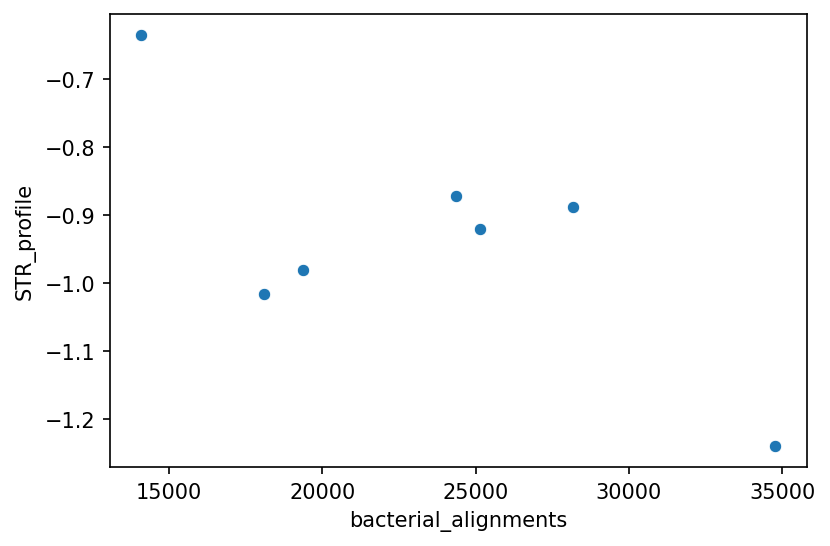

In [98]:
d = [   
        [ 1054, 34777, 1011050, -1.24 ],
        [ 649, 28167, 1242088, -0.888940 ],
        [ 612, 25154, 2057903, -0.920462 ],
        [ 1627, 24376, 1708005, -0.872526 ],
        [ 1657, 19358, 1952344, -0.981056 ],
        [ 1253 , 18097, 1414755, -1.016385 ],
    # [ 609, 15732, 0 ]
        [1236, 14102, 1343181, -0.635272],
 ]

d = pd.DataFrame(d, columns=['sample_id', 'bacterial_alignments', 'total_STR_reads', 'STR_profile'])

plt.figure(dpi=150)
sns.scatterplot(data=d, x='bacterial_alignments', y='STR_profile')

In [59]:
composition_summary[composition_summary['sample_id']=='1054'].sort_values('perc', ascending=False)

,sample_id,HRGM_name,count,perc,domain,phylum,class,order,family,genus,species,member_count,continents,country
901,1054,HRGM_Genome_0235,10652,30.629439,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus,483,Oceania;NA;North America;Asia;Europe,Mongolia;Austria;Denmark;South Korea;Netherlan...
936,1054,HRGM_Genome_0392,5084,14.618857,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium animalis,36,Europe;NA;Asia;North America,China;Spain;United States;NA
1021,1054,HRGM_Genome_1222,3367,9.681686,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Stenotrophomonas,Stenotrophomonas maltophilia_F,2,North America,United States
1474,1054,HRGM_Genome_5206,1492,4.290192,Bacteria,Firmicutes,Bacilli,Mycoplasmatales,Mycoplasmoidaceae,Ureaplasma,Ureaplasma parvum,3,North America,United States
1178,1054,HRGM_Genome_1823,1190,3.421802,Bacteria,Campylobacterota,Campylobacteria,Campylobacterales,Campylobacteraceae,Campylobacter_B,Campylobacter_B ureolyticus,16,Europe;North America,Canada;United States;Ireland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,1054,HRGM_Genome_0169,1,0.002875,Bacteria,Firmicutes_A,Clostridia,Tissierellales,Helcococcaceae,Parvimonas,,1,Europe,Austria
882,1054,HRGM_Genome_0182,1,0.002875,Bacteria,Actinobacteriota,Coriobacteriia,Coriobacteriales,Coriobacteriaceae,Collinsella,Collinsella ihuae,1,NaN,NaN
884,1054,HRGM_Genome_0187,1,0.002875,Bacteria,Firmicutes_A,Clostridia,Tissierellales,Helcococcaceae,Anaerococcus,Anaerococcus senegalensis,1,NaN,NaN
888,1054,HRGM_Genome_0192,1,0.002875,Bacteria,Firmicutes_A,Clostridia,Tissierellales,Helcococcaceae,Anaerococcus,Anaerococcus obesiensis,29,Europe;Asia;North America,Canada;Spain;Bangladesh;France;United States;U...


In [ ]:
'Fusobacterium animalis'